In [1]:
import numpy as np
from numpy import genfromtxt
import csv
import os

import deepSI
from deepSI import System_data

import matplotlib.pyplot as plt

import pysindy as ps

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = r"data//"

WIENER = "WienerHammerBenchmark"
SILVER = "SNLS80mV"
# change data set
DATA = SILVER
CSV = ".csv"

PATH = os.path.join(DATA_PATH, DATA+CSV)

# load data
data = genfromtxt(PATH, delimiter=",")

# drop nan's may need to be adjusted between data sets
mask = ~np.isnan(data)
data = data[mask[:,0],:]
data = data[:,:-1]

system_data = System_data(u=data[:,0],y=data[:,1])
train, test = system_data[40000:], system_data[:40000]

In [3]:
# load trained ss encoder
fit_sys_ss_enc = deepSI.load_system('models/silverbox_50_2')

In [4]:
test_sim_enc = fit_sys_ss_enc.apply_experiment(test, save_state=True)

# plt.plot(test.y)
# plt.plot(test.y - test_sim_enc.y)
# plt.title(f'test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test):.2%}')
# plt.show()

train_sim_enc = fit_sys_ss_enc.apply_experiment(train, save_state=True)

In [5]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

def center(y):
    return y-np.mean(y)

In [6]:
library_functions = [
        lambda x: 1,
        lambda x: x,
        lambda x: x**2,
        lambda x: x**3,
]

library_function_names = [
    lambda x: "1",
    lambda x: x,
    lambda x: x+"^2",
    lambda x: x+"^3",
]

custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

In [7]:
differentiation_method = ps.FiniteDifference(order=4)

x_train = train_sim_enc.x

# model specs
feature_library = ps.ConcatLibrary([ ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ(alpha=0, threshold= 0.1, verbose=True)#alpha=2, threshold= 0.1, 

model = ps.SINDy(feature_library=custom_library,
                 optimizer=stlsq_optimizer,
                 discrete_time = True
                 )

# fit
model.fit(x_train, u=train.u)
model.print()
model.coefficients()

x_test = test_sim_enc.x

x_dot_test_predicted = model.predict(x_test, u=test.u)
x_dot_test_simulated = model.simulate(x_test[0], u=test.u[:], t=test.u.shape[0])

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.0552e+02 ... 0.0000e+00 ...         15 ... 3.0552e+02
         1 ... 6.8796e+02 ... 0.0000e+00 ...         15 ... 6.8796e+02
(x0)[k+1] = -33838459236.694 1 + 16978036863.796 1 + 16860422373.010 1 + 0.318 x0[k] + -0.701 x1[k] + 2.994 u0[k] + 8.608 u0[k]^3
(x1)[k+1] = 111369358539.562 1 + -55621750254.340 1 + -55747608285.208 1 + 0.813 x0[k] + 1.141 x1[k] + -2.504 u0[k] + -0.299 u0[k]^2 + 5.786 u0[k]^3


In [8]:
x0_eye = np.sum(model.coefficients()[0][0:3])
x1_eye = np.sum(model.coefficients()[1][0:3])
print(x0_eye, x1_eye)

0.11206626892089844 0.01320648193359375


In [9]:
x1 = test_sim_enc.x[:,0]
x2 = test_sim_enc.x[:,1]

pred_NRMS = NRMS( x_dot_test_predicted[:-1,0], x1[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,0], x1)

print("x1 NRMS pred: ",pred_NRMS)
print("x1 NRMS simo: ",simo_NRMS)

pred_NRMS = NRMS( x_dot_test_predicted[:-1,1], x2[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:,1], x2)

print("x2 NRMS pred: ",pred_NRMS)
print("x2 NRMS simo: ",simo_NRMS)

x1 NRMS pred:  0.013809066342852233
x1 NRMS simo:  0.24622517062352423
x2 NRMS pred:  0.03776046349816259
x2 NRMS simo:  0.2701815647503462


In [10]:
differentiation_method = ps.FiniteDifference(order=4)

x_train = train.y
u_train = train_sim_enc.x

# model specs
feature_library = ps.ConcatLibrary([ ps.PolynomialLibrary(degree=3)]) #ps.IdentityLibrary(),

stlsq_optimizer = ps.STLSQ( verbose=True)#alpha=2, threshold= 0.1, 

model = ps.SINDy(feature_library=custom_library,
                 optimizer=stlsq_optimizer,
                 discrete_time = True
                 )

# fit
model.fit(x_train, u=u_train)
model.print()
model.coefficients()

x_test = test.y
u_test = test_sim_enc.x

x_dot_test_predicted = model.predict(x_test, u=u_test)
x_dot_test_simulated = model.simulate(x_test[0], u=u_test[:], t=u_test.shape[0])#

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.3526e+02 ... 3.0371e-01 ...          5 ... 3.3557e+02
         1 ... 5.1712e+01 ... 7.6875e-02 ...          3 ... 5.1789e+01
         2 ... 1.9585e+01 ... 2.1995e-02 ...          3 ... 1.9607e+01
(x0)[k+1] = -0.098 x0[k] + 0.227 u0[k] + -2.681 x0[k]^3


In [11]:
y = center(test.y)

x_dot_test_predicted = center(x_dot_test_predicted.flatten())
x_dot_test_simulated = center(x_dot_test_simulated.flatten())

pred_NRMS = NRMS( x_dot_test_predicted[:-1], y[1:])
simo_NRMS = NRMS( x_dot_test_simulated[:], y)

print("x1 NRMS pred: ",pred_NRMS)
print("x1 NRMS simo: ",simo_NRMS)


x1 NRMS pred:  0.20805581755920113
x1 NRMS simo:  0.19433559854270535


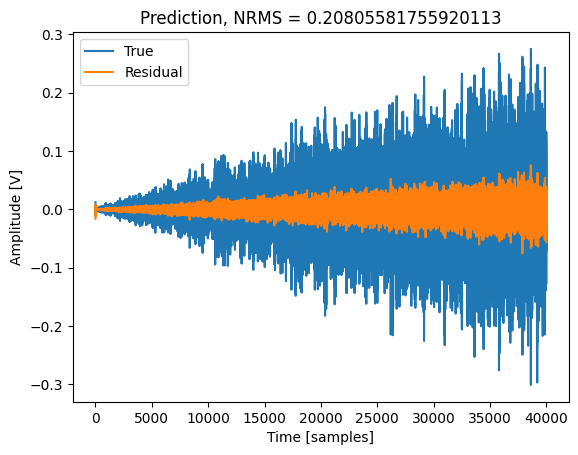

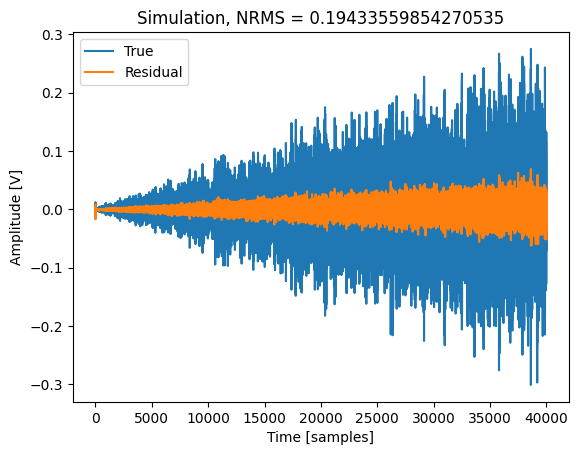

In [12]:
plt.plot(y[1:])
plt.plot(x_dot_test_predicted[:-1]-y[1:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Prediction, NRMS = "+str(pred_NRMS))
plt.legend(["True","Residual"])
plt.show()

plt.plot(y)
plt.plot(x_dot_test_simulated[:]-y[:])
plt.ylabel("Amplitude [V]")
plt.xlabel("Time [samples]")
plt.title("Simulation, NRMS = "+str(simo_NRMS))
plt.legend(["True","Residual"])
plt.show()